## **IMPORTING DATASET FROM KAGGLE IDD-LITE**

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"asmiagarwal","key":"f20f6d561cebf0b94a3868fe547858a4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d sounakp/idd-segmentation-lite


Dataset URL: https://www.kaggle.com/datasets/sounakp/idd-segmentation-lite
License(s): other


In [ ]:
!unzip idd-segmentation-lite.zip -d idd_lite_data


Streaming output truncated to the last 5000 lines.
  inflating: idd_lite_data/idd20k_lite/gtFine/train/135/330189_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/042143_inst_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/042143_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/141768_inst_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/141768_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/168441_inst_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/168441_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/205117_inst_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/205117_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/213416_inst_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/213416_label.png  
  inflating: idd_lite_data/idd20k_lite/gtFine/train/136/248393_inst_label.png  
  inflating: idd_li

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
import tensorflow as tf  # ✅ <-- THIS IS IMPORTANT
from tensorflow.keras.applications import Xception, MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


# **Map Image and Mask Files**

Processing: 662706_inst_label.png


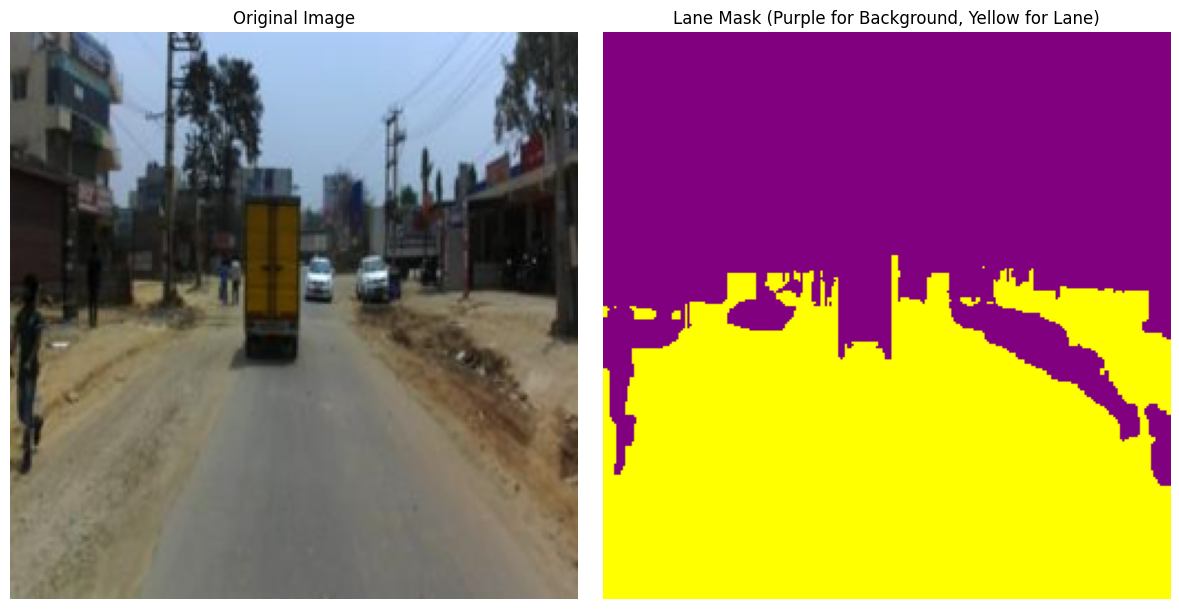

Processing: 601536_inst_label.png


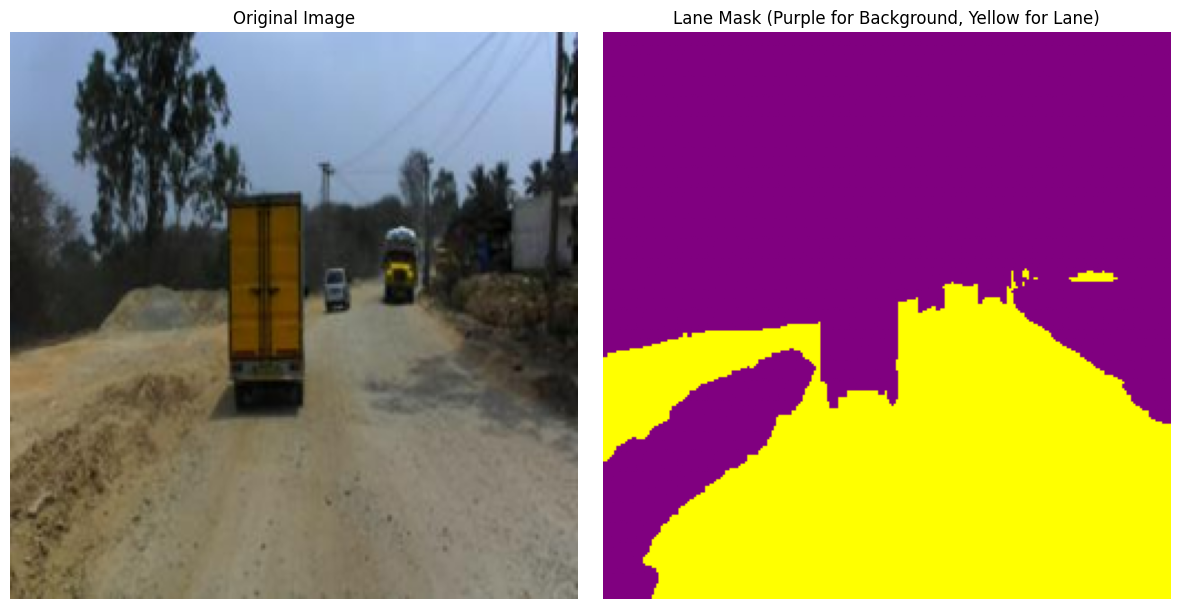

Processing: 092468_inst_label.png


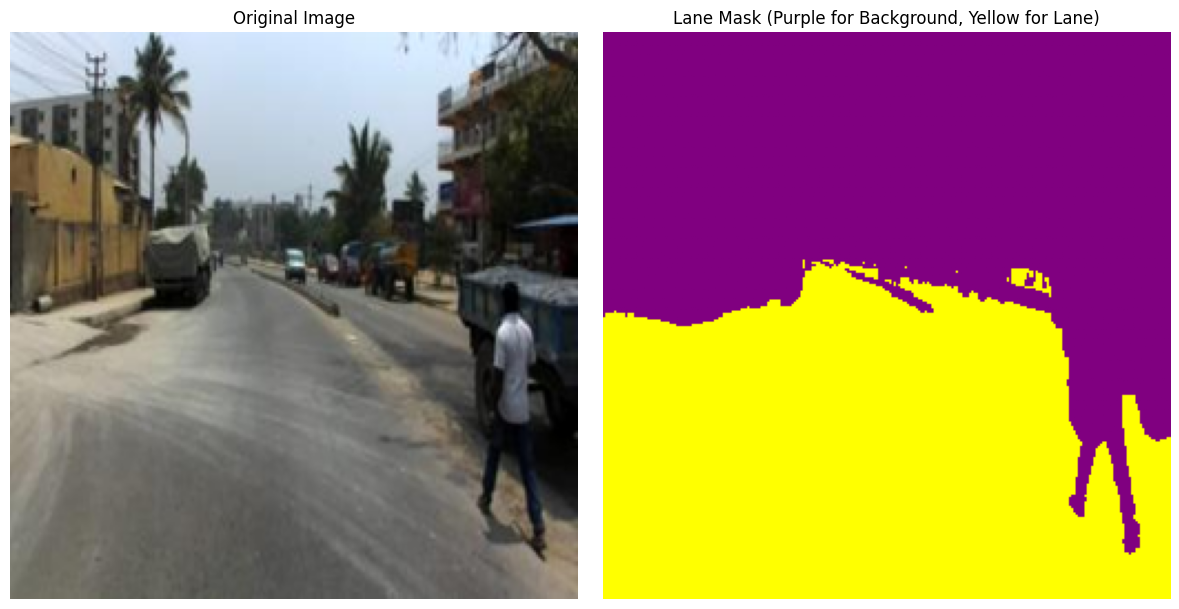

Processing: 725984_inst_label.png


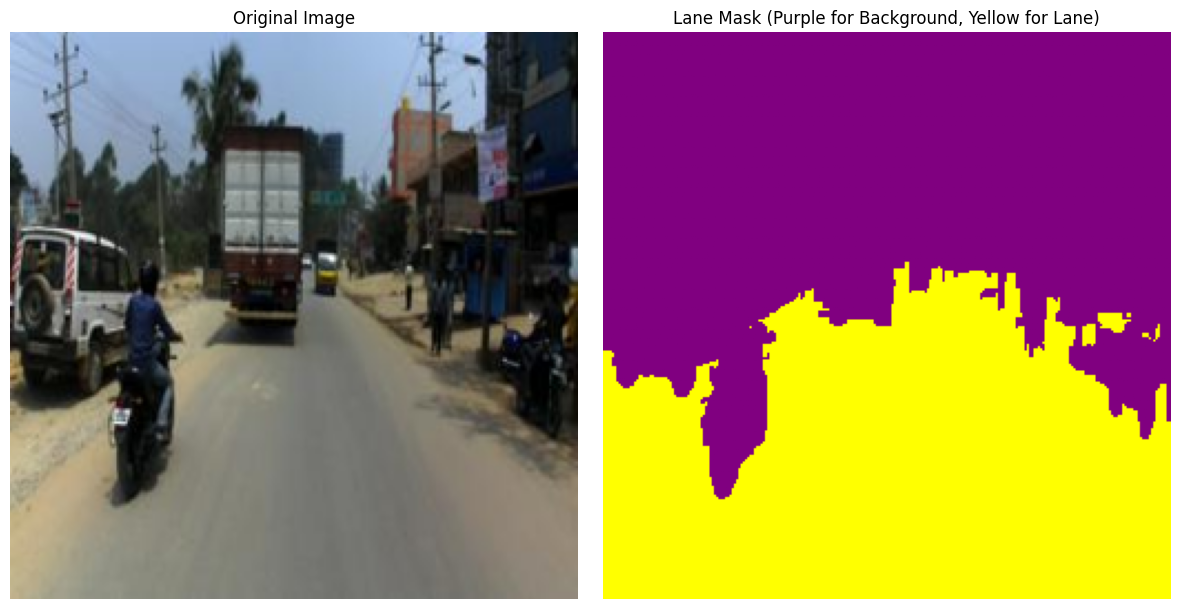

Processing: 340676_inst_label.png


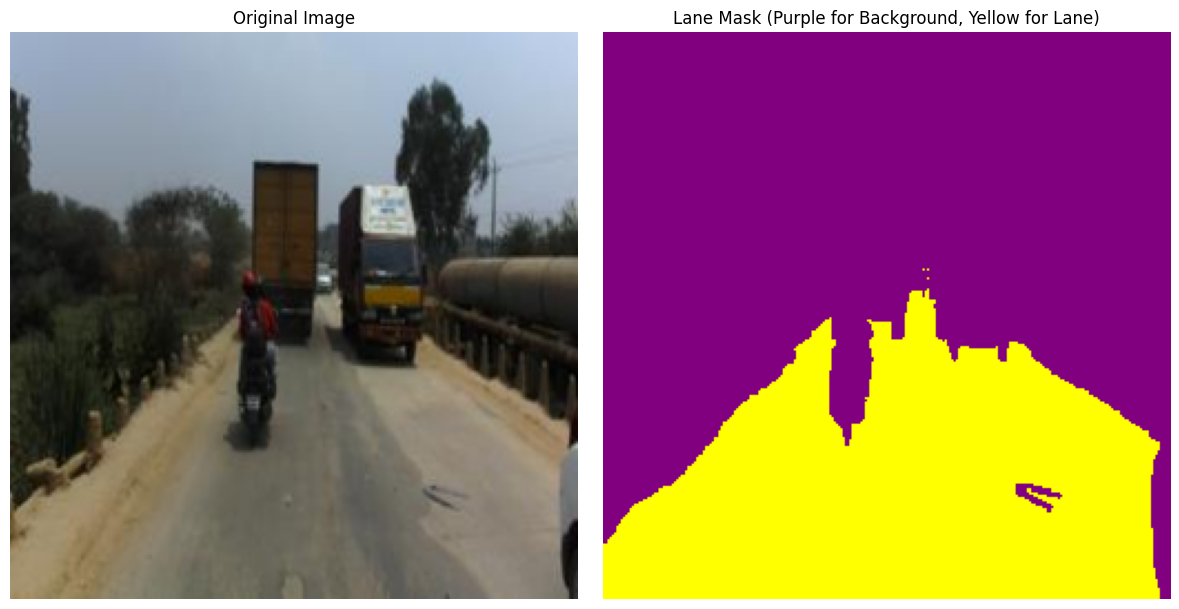

Processing: 502201_inst_label.png


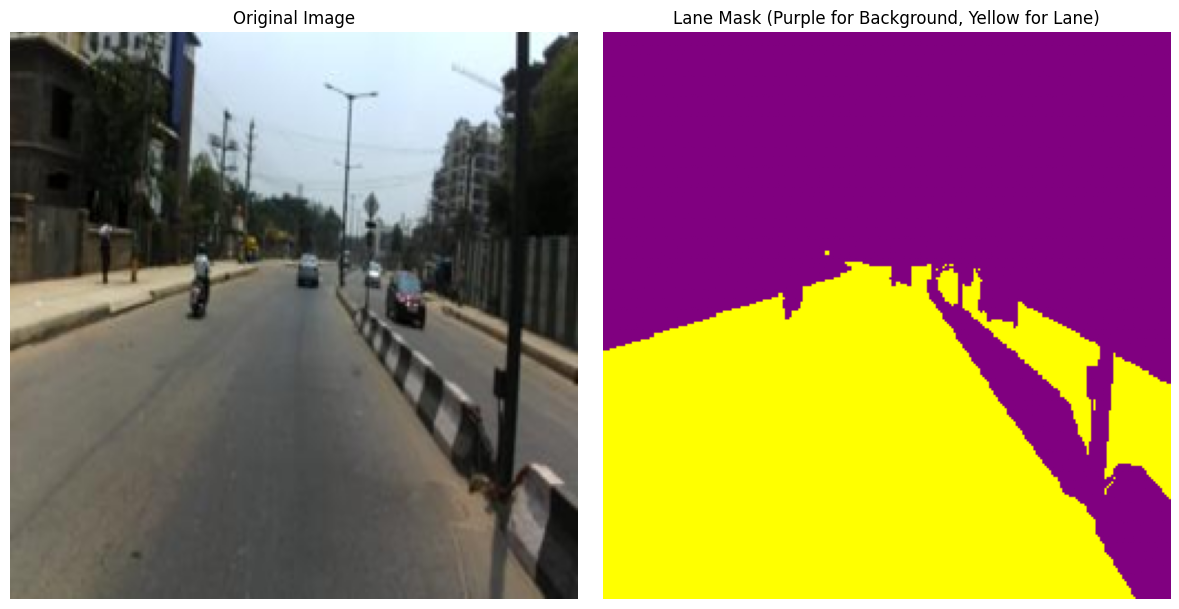

Processing: 820938_inst_label.png


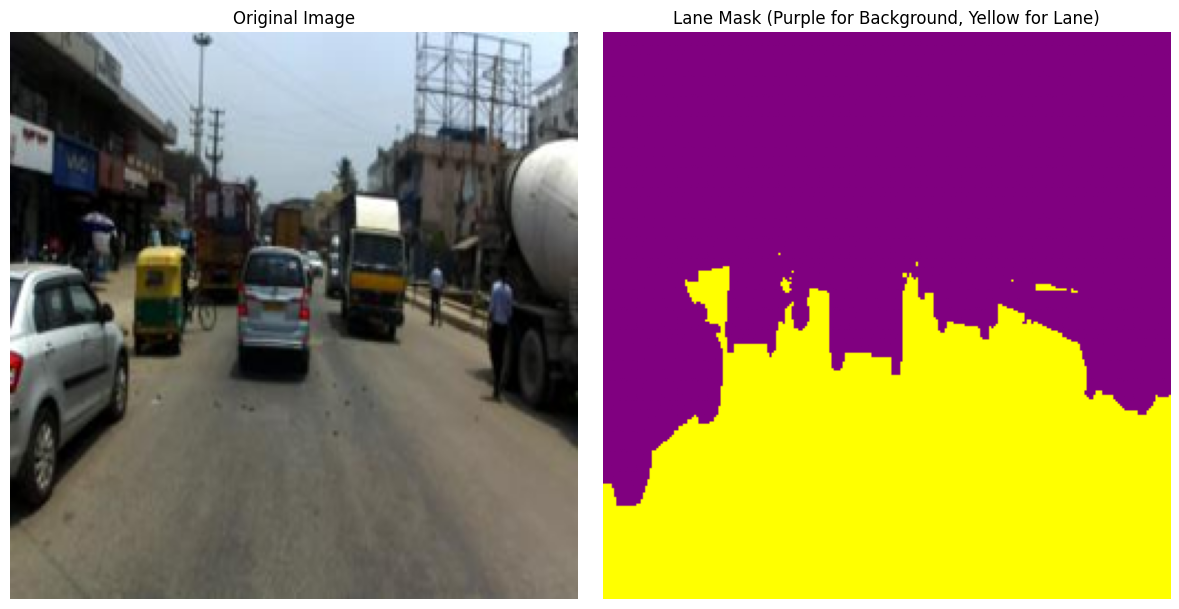

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

# Directory containing all instance label masks and images
mask_dir = "/content/idd_lite_data/idd20k_lite/gtFine/train/1"  # Mask directory
image_dir = "/content/idd_lite_data/idd20k_lite/leftImg8bit/train/1"  # Image directory (JPEG)

# List all jpg files in the mask directory
mask_files = [f for f in os.listdir(mask_dir) if f.endswith("_inst_label.png")]

# Custom colormap: purple background, yellow lane
colors = [(128/255, 0, 128/255), (1, 1, 0)]  # Purple background, yellow lane
custom_cmap = ListedColormap(colors)

# Setup matplotlib interactive mode for real-time updates
plt.ion()

# Loop through each file
for mask_file in mask_files:
    mask_path = os.path.join(mask_dir, mask_file)

    # Get the image file corresponding to the mask (assuming the same base name)
    image_file = mask_file.replace("_inst_label.png", "_image.jpg")  # Adjust for your image format
    image_path = os.path.join(image_dir, image_file)

    print(f"Processing: {mask_file}")

    # Load and preprocess the mask
    mask = Image.open(mask_path).convert('L').resize((256, 256), resample=Image.NEAREST)
    mask_np = np.array(mask)

    # Generate binary mask for lane (ID = 0)
    lane_mask = np.where(mask_np == 0, 1, 0)

    # Load the original image and resize (adjust size to match mask)
    original_image = Image.open(image_path).resize((256, 256))

    # Create a figure with 2 subplots (side-by-side)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image in the first subplot
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Remove axis

    # Display the lane mask in the second subplot
    axes[1].imshow(lane_mask, cmap=custom_cmap, vmin=0, vmax=1)
    axes[1].set_title("Lane Mask (Purple for Background, Yellow for Lane)")
    axes[1].axis('off')  # Remove axis

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

    # Pause to allow the plot to be rendered
    plt.pause(0.1)



# Turn off interactive mode when done
plt.ioff()
plt.show()  # Ensure the last plot is shown


In [ ]:
IMG_DIR = "/content/idd_lite_data/idd20k_lite/leftImg8bit/train"
MASK_DIR = "/content/idd_lite_data/idd20k_lite/gtFine/train"


In [ ]:
!pip install tensorflow matplotlib


# **Training The Model**

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# === Set up paths ===
IMG_DIR = "/content/idd_lite_data/idd20k_lite/leftImg8bit/train/"
MASK_DIR = "/content/idd_lite_data/idd20k_lite/gtFine/train/"

# === Collect image and mask paths ===
image_paths = sorted(glob.glob(os.path.join(IMG_DIR, "**", "*.jpg"), recursive=True))
mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, "**", "*_inst_label.png"), recursive=True))

# === Split into training and validation ===
split_index = int(len(image_paths) * 0.85)
train_image_paths = image_paths[:split_index]
train_mask_paths = mask_paths[:split_index]
val_image_paths = image_paths[split_index:]
val_mask_paths = mask_paths[split_index:]

In [ ]:
# === Dataset loading and preprocessing ===
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    # Convert to binary mask (lane = 0)
    mask = tf.cast(tf.equal(mask, 0), tf.float32)
    return image, mask

def random_flip(image, mask):
    image = tf.image.random_flip_left_right(image)
    mask = tf.image.random_flip_left_right(mask)
    return image, mask

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

train_dataset = train_dataset.map(load_image_and_mask).map(random_flip)
val_dataset = val_dataset.map(load_image_and_mask)

batch_size = 16
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# === IoU metric ===
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.clip_by_value(y_true + y_pred, 0, 1))
    return intersection / (union + 1e-6)

In [ ]:
# === DeepLabv3+ model ===
def create_deeplabv3plus(input_shape):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.get_layer('block13_sepconv2_bn').output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# === Compile and train ===
input_shape = (256, 256, 3)
model = create_deeplabv3plus(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 127, 127,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 127, 127,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 125, 125,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 125, 125,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 125, 125,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 125, 125,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 125, 125,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 125, 125,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 125, 125,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 125, 125,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 63, 63,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 63,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 63, 63,    │          0 │ add[0][0]       

 Total params: 15,356,969 (58.58 MB)

 Trainable params: 15,311,657 (58.41 MB)

 Non-trainable params: 45,312 (177.00 KB)

In [ ]:
checkpoint = ModelCheckpoint("model_best.h5", save_best_only=True, verbose=1)
model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[checkpoint])

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8733 - iou_metric: 0.6995 - loss: 0.2806
Epoch 1: val_loss improved from inf to 0.20508, saving model to model_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 97s 685ms/step - accuracy: 0.8736 - iou_metric: 0.7001 - loss: 0.2798 - val_accuracy: 0.9182 - val_iou_metric: 0.7822 - val_loss: 0.2051
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9166 - iou_metric: 0.7753 - loss: 0.1810
Epoch 2: val_loss improved from 0.20508 to 0.17063, saving model to model_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - accuracy: 0.9166 - iou_metric: 0.7753 - loss: 0.1809 - val_accuracy: 0.9254 - val_iou_metric: 0.8007 - val_loss: 0.1706
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9195 - iou_metric: 0.7777 - loss: 0.1726
Epoch 3: val_loss improved from 0.17063 to 0.16419, saving model to model_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - accuracy: 0.9195 - iou_metric: 0.7777 - loss: 0.1726 - val_accuracy: 0.9253 - val_iou_metric: 0.7865 - val_loss: 0.1642
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9219 - iou_metric: 0.7856 - loss: 0.1635
Epoch 4: val_loss improved from 0.16419 to 0.14518, saving model to model_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - accuracy: 0.9219 - iou_metric: 0.7856 - loss: 0.1635 - val_accuracy: 0.9349 - val_iou_metric: 0.8047 - val_loss: 0.1452
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9232 - iou_metric: 0.7870 - loss: 0.1603
Epoch 5: val_loss did not improve from 0.14518
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - accuracy: 0.9232 - iou_metric: 0.7870 - loss: 0.1603 - val_accuracy: 0.9284 - val_iou_metric: 0.7915 - val_loss: 0.1524
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9243 - iou_metric: 0.7900 - loss: 0.1546
Epoch 6: val_loss improved from 0.14518 to 0.14453, saving model to model_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.9243 - iou_metric: 0.7900 - loss: 0.1545 - val_accuracy: 0.9362 - val_iou_metric: 0.8125 - val_loss: 0.1445
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9249 - iou_metric: 0.7947 - loss: 0.1540
Epoch 7: val_loss did not improve from 0.14453
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 267ms/step - accuracy: 0.9249 - iou_metric: 0.7946 - loss: 0.1540 - val_accuracy: 0.9320 - val_iou_metric: 0.7994 - val_loss: 0.1464
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9247 - iou_metric: 0.7923 - loss: 0.1505
Epoch 8: val_loss improved from 0.14453 to 0.14249, saving model to model_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 0.9248 - iou_metric: 0.7923 - loss: 0.1504 - val_accuracy: 0.9318 - val_iou_metric: 0.7996 - val_loss: 0.1425
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9286 - iou_metric: 0.8027 - loss: 0.1468
Epoch 9: val_loss improved from 0.14249 to 0.14071, saving model to model_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/step - accuracy: 0.9286 - iou_metric: 0.8027 - loss: 0.1468 - val_accuracy: 0.9365 - val_iou_metric: 0.8191 - val_loss: 0.1407
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9255 - iou_metric: 0.7942 - loss: 0.1499
Epoch 10: val_loss did not improve from 0.14071
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - accuracy: 0.9255 - iou_metric: 0.7942 - loss: 0.1499 - val_accuracy: 0.9292 - val_iou_metric: 0.7960 - val_loss: 0.1455


Total images found: 7
Sample filenames: ['820938_image.jpg', '340676_image.jpg', '725984_image.jpg']


100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


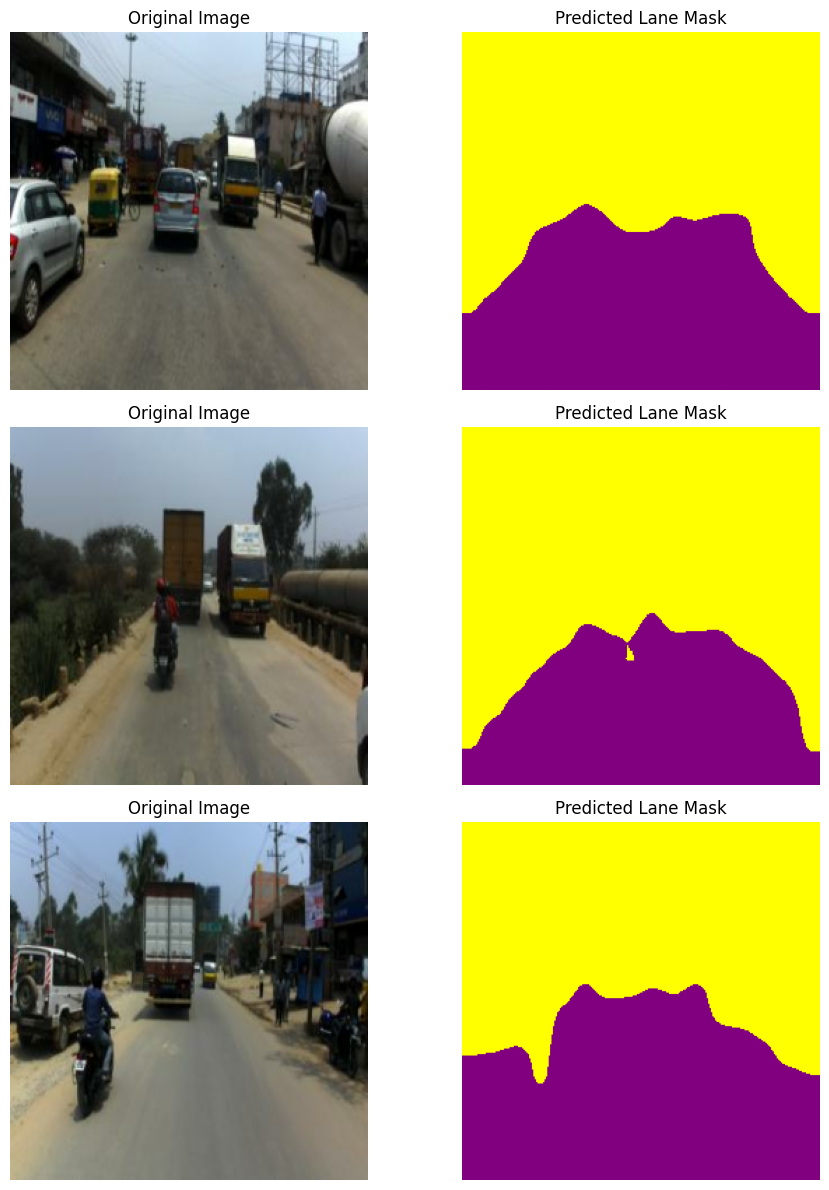

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from matplotlib.colors import ListedColormap

# Custom colormap: yellow (background=0), purple (lane=1)
colors = [(1, 1, 0), (128/255, 0, 128/255)]
custom_cmap = ListedColormap(colors)

# Directory path
campus_dir = "/content/idd_lite_data/idd20k_lite/leftImg8bit/train/1"
campus_images_names = [name for name in os.listdir(campus_dir) if name.endswith((".jpg", ".jpeg", ".png"))]

# DEBUG: Check loaded files
print("Total images found:", len(campus_images_names))
print("Sample filenames:", campus_images_names[:3])

# Limit number of samples
num_samples = 3  # you can change this to more
campus_images_names = campus_images_names[:num_samples]

# Lists to hold results
images = []
pred_masks = []

# Prediction loop
for name in tqdm(campus_images_names):
    path = os.path.join(campus_dir, name)
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)  # More robust than decode_jpeg/png
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    images.append(image.numpy())

    pred = model.predict(tf.expand_dims(image, axis=0), verbose=0)[0]
    pred_binary = (pred > 0.5).astype(np.uint8).squeeze()
    pred_masks.append(pred_binary)

# Visualization
if len(images) == 0:
    print("❌ No images loaded. Check the directory path or image extensions.")
else:
    fig, ax = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))

    if num_samples == 1:
        ax[0].imshow(images[0])
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(pred_masks[0], cmap=custom_cmap, vmin=0, vmax=1)
        ax[1].set_title("Predicted Lane Mask")
        ax[1].axis('off')
    else:
        for i in range(num_samples):
            ax[i][0].imshow(images[i])
            ax[i][0].set_title("Original Image")
            ax[i][0].axis('off')

            ax[i][1].imshow(pred_masks[i], cmap=custom_cmap, vmin=0, vmax=1)
            ax[i][1].set_title("Predicted Lane Mask")
            ax[i][1].axis('off')

    plt.tight_layout()
    plt.show()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 258ms/step - accuracy: 0.9255 - iou_metric: 0.7916 - loss: 0.1467 - val_accuracy: 0.9365 - val_iou_metric: 0.8145 - val_loss: 0.1356
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 261ms/step - accuracy: 0.9257 - iou_metric: 0.7925 - loss: 0.1457 - val_accuracy: 0.9237 - val_iou_metric: 0.7775 - val_loss: 0.1550
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.9283 - iou_metric: 0.8001 - loss: 0.1427 - val_accuracy: 0.9426 - val_iou_metric: 0.8289 - val_loss: 0.1314
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - accuracy: 0.9285 - iou_metric: 0.8007 - loss: 0.1403 - val_accuracy: 0.9373 - val_iou_metric: 0.8135 - val_loss: 0.1353
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.9286 - iou_metric: 0.8021 - loss: 0.1399 - val_accuracy: 0.9402 - val_iou_metric: 0.8217 - val_loss: 0.1331
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 268ms/step - accuracy: 0.9302 - iou_metric: 0.8049 - loss: 0.1366 - val_accuracy: 0

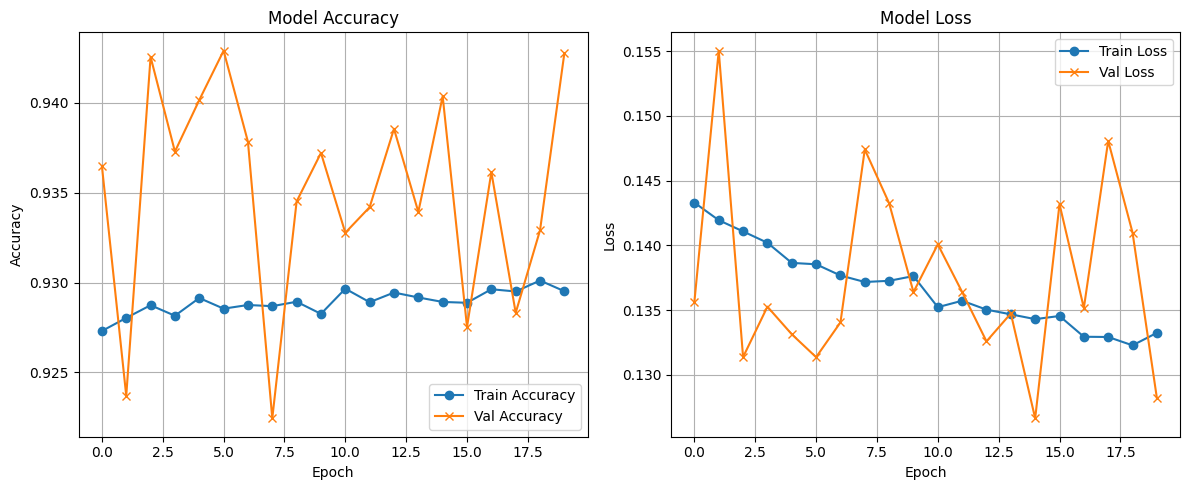

In [ ]:
# Train the model and store history
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20  # Adjust as needed
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


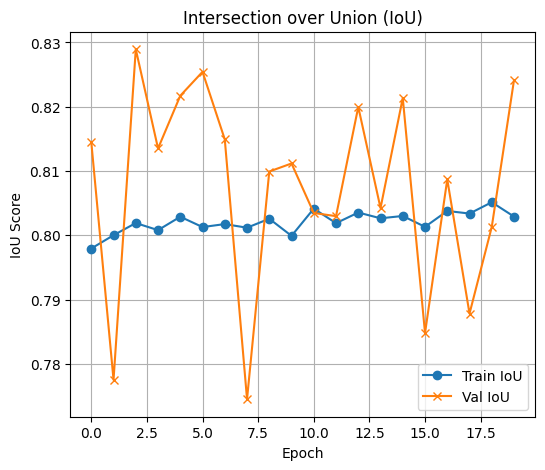

In [ ]:
# Plot IoU
plt.figure(figsize=(6, 5))
plt.plot(history.history['iou_metric'], label='Train IoU', marker='o')
plt.plot(history.history['val_iou_metric'], label='Val IoU', marker='x')
plt.title('Intersection over Union (IoU)')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


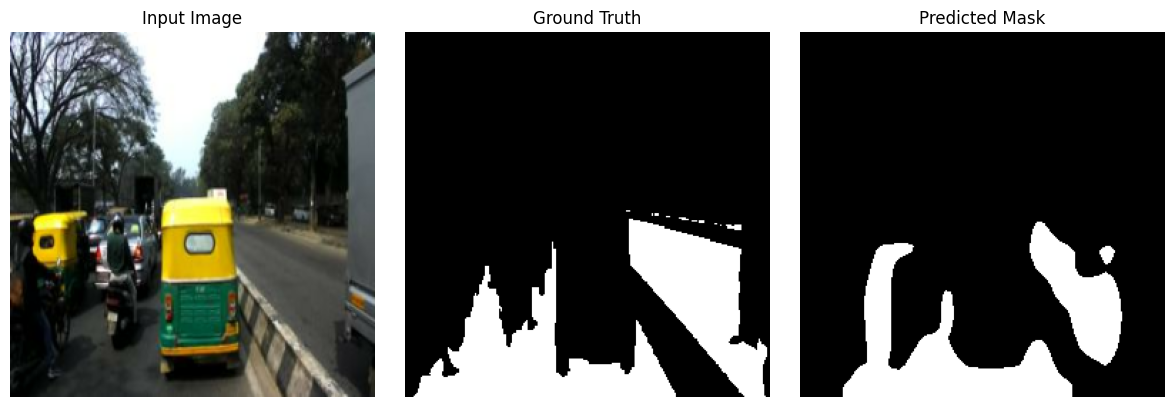

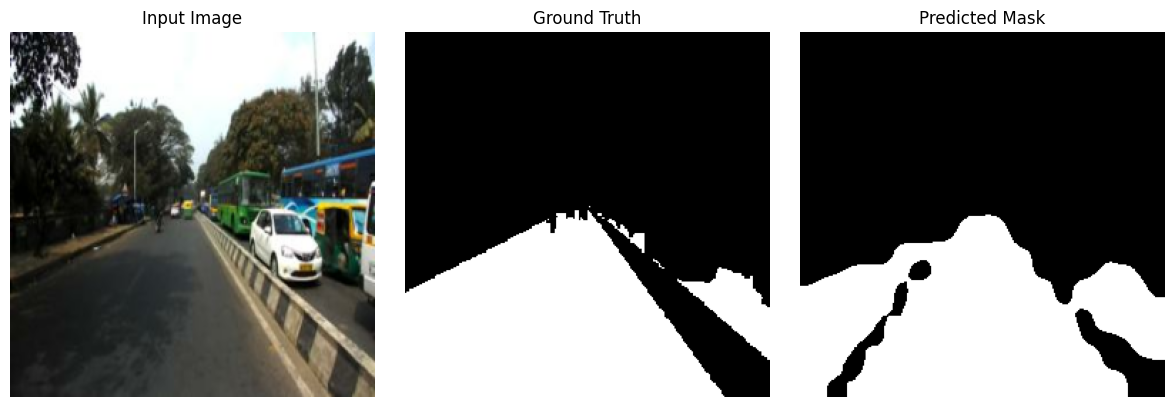

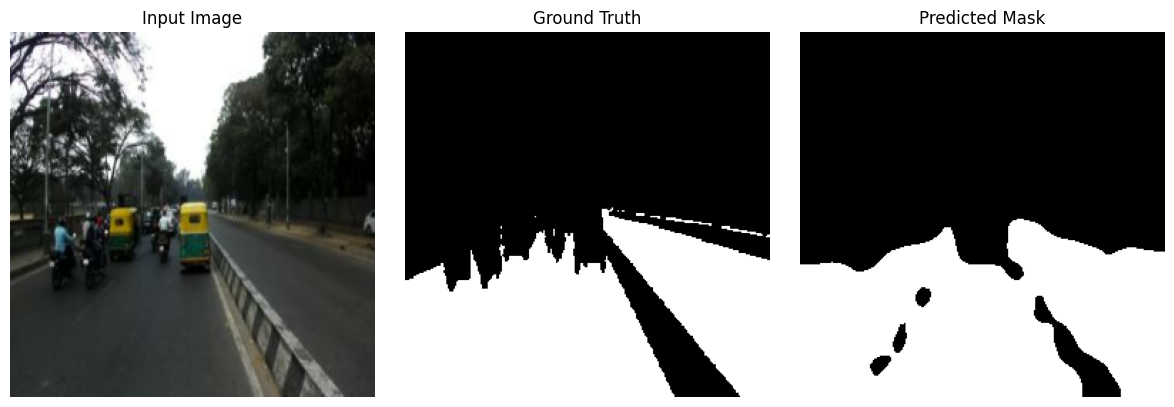

In [ ]:
# Visualize predictions on a few validation samples
import random

for images, masks in val_dataset.take(1):
    preds = model.predict(images)
    for i in range(3):  # Show 3 samples
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Input Image")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(tf.squeeze(masks[i]), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(tf.squeeze(preds[i]) > 0.5, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
